# SAPNet Model for automatic single molecule identification
# By: Mulusew W. Yaltaye
# Importing libraries and modules

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, Flatten, Dropout, Dense, BatchNormalization, Activation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import datetime

import sklearn
from sklearn.metrics import confusion_matrix, roc_curve, auc
import pandas as pd
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score, precision_recall_curve
import sklearn.metrics as sklearn_metrics
from itertools import cycle
from scipy.interpolate import interp1d
import seaborn as sns


# Functions to plot the training, validation performance measures and the test set accuracy

In [19]:
np.set_printoptions(threshold=np.inf)
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    # Draw loss, AUC, precision and recall curve
    plt.figure(figsize=(8, 4), dpi=800)
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        plt.tight_layout()

def plot_cm(labels, predictions):
    # Draw confusing matrix
    cm = confusion_matrix(labels, predictions)
    plt.figure()
    sns.heatmap(cm, cmap="Oranges")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

def plot_prc(name, labels, predictions, **kwargs):
    # Draw Precision_Recall curve
    precision = dict()
    recall = dict()
    average_precision = dict()
    n_classes=1332
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(labels[:, i], predictions[:, i])
        average_precision[i] = average_precision_score(labels[:, i], predictions[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(labels.ravel(), predictions.ravel())
    average_precision["micro"] = average_precision_score(labels, predictions, average="micro")
    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Average precision score, micro-averaged over all classes: AP={0:0.4f}'.format(average_precision["micro"]))


def load_spectrum_file(dir_path):
    data = []
    label = []
    file_dir_list = os.listdir(dir_path)
    for file_dir in file_dir_list:
        file_list = os.listdir(dir_path + '/' + file_dir)
        for filename in file_list:
            file_path = dir_path + '/' + file_dir + '/' + filename
            x, y = np.loadtxt(file_path, dtype=float, comments='#', delimiter=',', unpack=True)
            data.append(y)
            label.append(file_dir)
    return data, label

# CNN Architecture

In [24]:
from keras.regularizers import l2

model = Sequential()
model.add(keras.Input(shape=(1443, 1)))

# Add some regularization to the convolutional layers
reg_strength = 1e-4

# Convolutional Layers
conv_layers = [64, 128, 256, 512]
for cl in conv_layers:
    model.add(Conv1D(cl, 3, activation='relu', kernel_regularizer=l2(reg_strength)))
    model.add(BatchNormalization())
    model.add(Conv1D(cl, 3, activation='relu', kernel_regularizer=l2(reg_strength)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, strides=2))
    model.add(Dropout(0.3))  
    
# Flattening layer
model.add(Flatten())

# Dense Layers
model.add(Dense(512, kernel_regularizer=l2(reg_strength)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512, kernel_regularizer=l2(reg_strength)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))  

model.summary()

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')
]
model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS,
)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 1441, 64)          256       
_________________________________________________________________
batch_normalization_42 (Batc (None, 1441, 64)          256       
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 1439, 64)          12352     
_________________________________________________________________
batch_normalization_43 (Batc (None, 1439, 64)          256       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 719, 64)           0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 719, 64)           0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 717, 128)         

## Loading data

In [21]:
print("Loading the dataset...")
# change the directory the dataset accordingly
data, label = load_spectrum_file('Z:\Mulusew Yaltaye\Cindy')  

data = np.array(data)
data = tf.reshape(data, [data.shape[0], data.shape[1], 1])
# Binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(label)
# Split the data into train and test sets with a 70/30 split, ensuring that the class proportions are roughly the same in both sets
train_data, test_data, train_label, test_label = train_test_split(np.array(data), labels, train_size=0.7, test_size=0.3, stratify=labels, shuffle=True)
print("Completed!")

Loading the dataset...
Completed!


Epoch 1/80
31/31 [==============================] - 59s 2s/step - loss: 1.0579 - tp: 328.0000 - fp: 45.0000 - tn: 275.0000 - fn: 334.0000 - accuracy: 0.6141 - precision: 0.8794 - recall: 0.4955 - auc: 0.7562 - prc: 0.8674 - val_loss: 0.9678 - val_tp: 171.0000 - val_fp: 75.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6951 - val_precision: 0.6951 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.6951
Epoch 2/80
31/31 [==============================] - 63s 2s/step - loss: 0.7462 - tp: 497.0000 - fp: 30.0000 - tn: 290.0000 - fn: 165.0000 - accuracy: 0.8014 - precision: 0.9431 - recall: 0.7508 - auc: 0.9187 - prc: 0.9547 - val_loss: 0.9303 - val_tp: 171.0000 - val_fp: 75.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6951 - val_precision: 0.6951 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.6951
Epoch 3/80
31/31 [==============================] - 66s 2s/step - loss: 0.6465 - tp: 560.0000 - fp: 33.0000 - tn: 287.0000 - fn: 102.0000 - accuracy: 0.

31/31 [==============================] - 85s 3s/step - loss: 0.3512 - tp: 656.0000 - fp: 9.0000 - tn: 311.0000 - fn: 6.0000 - accuracy: 0.9847 - precision: 0.9865 - recall: 0.9909 - auc: 0.9995 - prc: 0.9997 - val_loss: 0.5599 - val_tp: 162.0000 - val_fp: 17.0000 - val_tn: 58.0000 - val_fn: 9.0000 - val_accuracy: 0.8943 - val_precision: 0.9050 - val_recall: 0.9474 - val_auc: 0.9551 - val_prc: 0.9791
Epoch 21/80
31/31 [==============================] - 89s 3s/step - loss: 0.3470 - tp: 654.0000 - fp: 6.0000 - tn: 314.0000 - fn: 8.0000 - accuracy: 0.9857 - precision: 0.9909 - recall: 0.9879 - auc: 0.9995 - prc: 0.9998 - val_loss: 0.6464 - val_tp: 167.0000 - val_fp: 26.0000 - val_tn: 49.0000 - val_fn: 4.0000 - val_accuracy: 0.8780 - val_precision: 0.8653 - val_recall: 0.9766 - val_auc: 0.9342 - val_prc: 0.9667
Epoch 22/80
31/31 [==============================] - 70s 2s/step - loss: 0.3598 - tp: 654.0000 - fp: 10.0000 - tn: 310.0000 - fn: 8.0000 - accuracy: 0.9817 - precision: 0.9849 - reca

Epoch 40/80
31/31 [==============================] - 60s 2s/step - loss: 0.3198 - tp: 660.0000 - fp: 1.0000 - tn: 319.0000 - fn: 2.0000 - accuracy: 0.9969 - precision: 0.9985 - recall: 0.9970 - auc: 0.9999 - prc: 1.0000 - val_loss: 0.6999 - val_tp: 165.0000 - val_fp: 20.0000 - val_tn: 55.0000 - val_fn: 6.0000 - val_accuracy: 0.8943 - val_precision: 0.8919 - val_recall: 0.9649 - val_auc: 0.9384 - val_prc: 0.9569
Epoch 41/80
31/31 [==============================] - 63s 2s/step - loss: 0.3186 - tp: 659.0000 - fp: 3.0000 - tn: 317.0000 - fn: 3.0000 - accuracy: 0.9939 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - prc: 1.0000 - val_loss: 0.6018 - val_tp: 167.0000 - val_fp: 17.0000 - val_tn: 58.0000 - val_fn: 4.0000 - val_accuracy: 0.9146 - val_precision: 0.9076 - val_recall: 0.9766 - val_auc: 0.9574 - val_prc: 0.9691
Epoch 42/80
31/31 [==============================] - 68s 2s/step - loss: 0.3236 - tp: 661.0000 - fp: 2.0000 - tn: 318.0000 - fn: 1.0000 - accuracy: 0.9969 - precision: 0.

Epoch 60/80
31/31 [==============================] - 57s 2s/step - loss: 0.3037 - tp: 662.0000 - fp: 1.0000 - tn: 319.0000 - fn: 0.0000e+00 - accuracy: 0.9990 - precision: 0.9985 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.5302 - val_tp: 167.0000 - val_fp: 7.0000 - val_tn: 68.0000 - val_fn: 4.0000 - val_accuracy: 0.9553 - val_precision: 0.9598 - val_recall: 0.9766 - val_auc: 0.9580 - val_prc: 0.9668
Epoch 61/80
31/31 [==============================] - 58s 2s/step - loss: 0.3097 - tp: 657.0000 - fp: 0.0000e+00 - tn: 320.0000 - fn: 5.0000 - accuracy: 0.9949 - precision: 1.0000 - recall: 0.9924 - auc: 0.9999 - prc: 1.0000 - val_loss: 0.5918 - val_tp: 164.0000 - val_fp: 9.0000 - val_tn: 66.0000 - val_fn: 7.0000 - val_accuracy: 0.9350 - val_precision: 0.9480 - val_recall: 0.9591 - val_auc: 0.9483 - val_prc: 0.9613
Epoch 62/80
31/31 [==============================] - 57s 2s/step - loss: 0.3098 - tp: 659.0000 - fp: 1.0000 - tn: 319.0000 - fn: 3.0000 - accuracy: 0.9959 - precisi

Epoch 80/80
31/31 [==============================] - 67s 2s/step - loss: 0.3021 - tp: 659.0000 - fp: 1.0000 - tn: 319.0000 - fn: 3.0000 - accuracy: 0.9959 - precision: 0.9985 - recall: 0.9955 - auc: 0.9998 - prc: 0.9999 - val_loss: 0.4575 - val_tp: 170.0000 - val_fp: 7.0000 - val_tn: 68.0000 - val_fn: 1.0000 - val_accuracy: 0.9675 - val_precision: 0.9605 - val_recall: 0.9942 - val_auc: 0.9702 - val_prc: 0.9749
17/17 - 5s - loss: 0.4528 - tp: 353.0000 - fp: 17.0000 - tn: 152.0000 - fn: 5.0000 - accuracy: 0.9583 - precision: 0.9541 - recall: 0.9860 - auc: 0.9823 - prc: 0.9863
loss: 0.4528
accuracy: 0.9583
F1_score: 0.9698


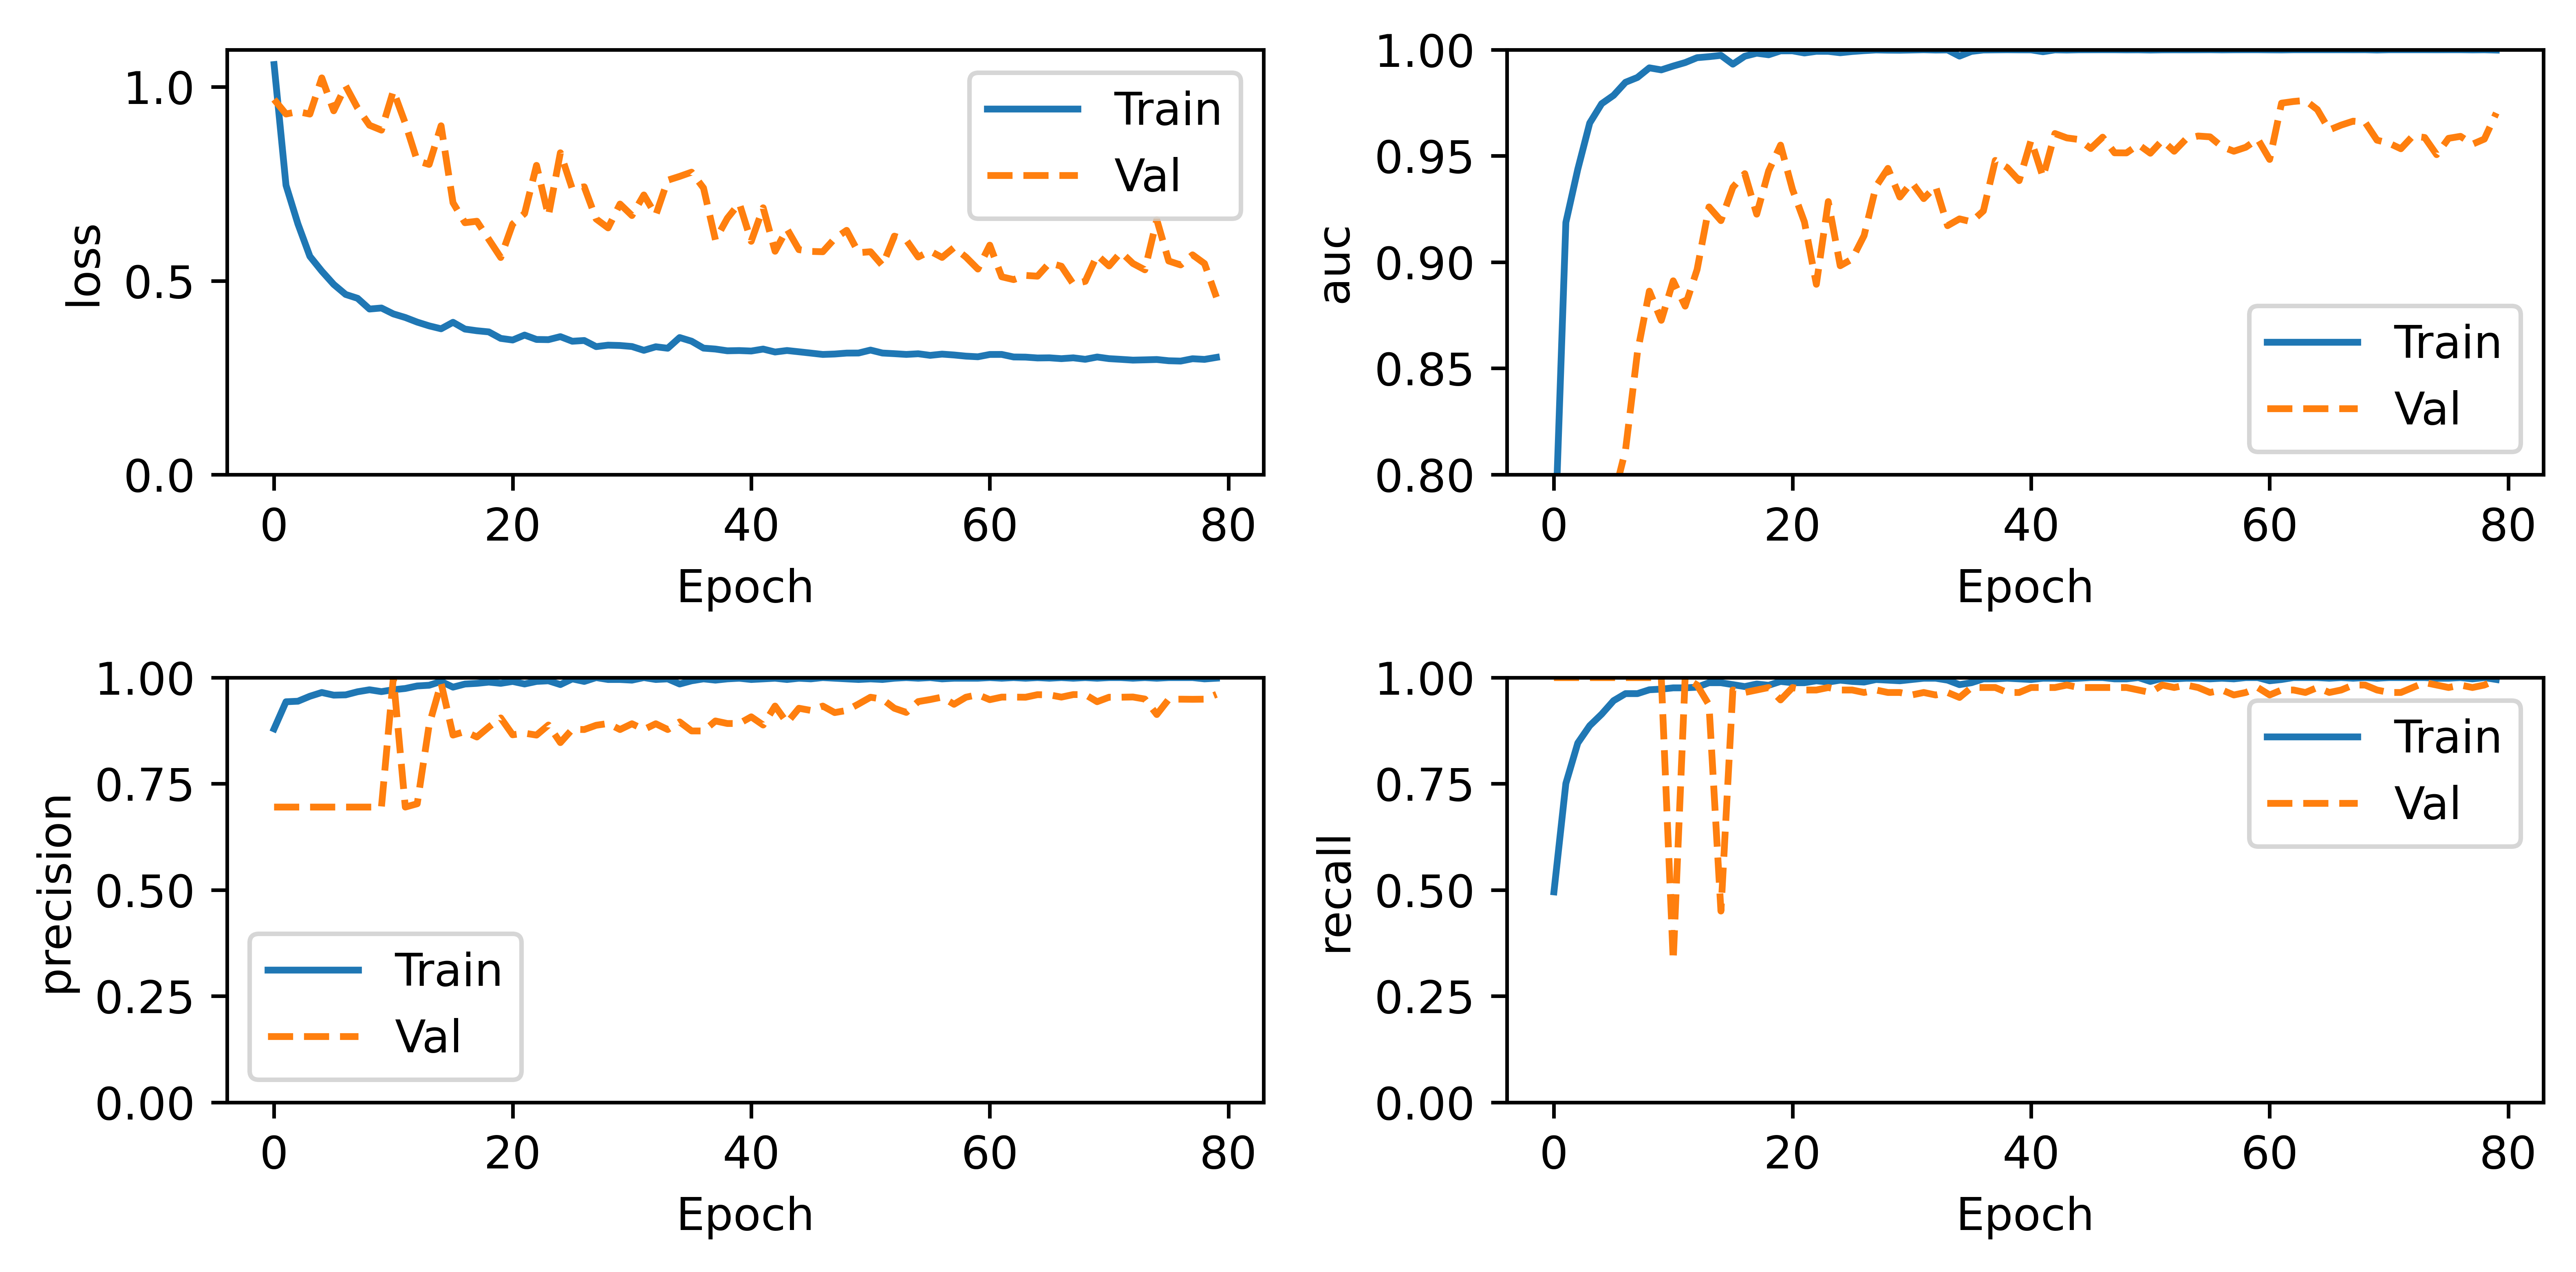

Classification_report               precision    recall  f1-score   support

           0     1.0000    0.0000    0.0000       169
           1     0.6793    1.0000    0.8090       358

    accuracy                         0.6793       527
   macro avg     0.8397    0.5000    0.4045       527
weighted avg     0.7822    0.6793    0.5496       527

accuracy_score 0.6793168880455408
------Weighted------
Weighted precision 0.782154546338337
Weighted recall 0.6793168880455408
Weighted f1-score 0.5495942280684828


In [25]:
# Define early stopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=2, patience=20, mode='max', restore_best_weights=True)
# Train the model on the train data 
h = model.fit(train_data, train_label, batch_size=32, epochs=80, verbose=1, validation_split=0.2, callbacks=[early_stopping])
# Plot the training and validation accuracy and loss curves
plot_metrics(h)
# Evaluate the model on the test data and print the loss, accuracy, and F1 score
results = model.evaluate(test_data, test_label, batch_size=32, return_dict=True, verbose=2)
F1_score = 2 * (results['precision'] * results['recall']) / (results['precision'] + results['recall'])
print("loss: {:0.4f}".format(results['loss']))
print("accuracy: {:0.4f}".format(results['accuracy']))
print("F1_score: {:0.4f}".format(F1_score))
# Save and show the plot of the training and validation accuracy and loss curves
plt.savefig('C:/Users/myaltaye22/Desktop/myfile/Machine learning based spectrum classification/python/1D_deep_CNN_model_train_curve.jpeg')
plt.show()
# Predict the labels for the test data and print the classification report and accuracy score
test_predictions = model.predict(test_data, batch_size=32)
y_true = test_label
y_pred = test_predictions
for i in range(len(y_pred)):
    max_value = max(y_pred[i])
    if max_value == 0:
        print(i, ":")
        print("y_true:")
        print(y_true[i])
        print("y_pred:")
        print(y_pred[i])

    for j in range(len(y_pred[i])):
        if max_value==y_pred[i][j]:
            y_pred[i][j]=1
        else:
            y_pred[i][j]=0

print('Classification_report', sklearn_metrics.classification_report(y_true, y_pred, digits=4, zero_division=1))
print('accuracy_score', sklearn_metrics.accuracy_score(y_true, y_pred))
print('------Weighted------')
print('Weighted precision', precision_score(y_true, y_pred, average='weighted', zero_division=1))
print('Weighted recall', recall_score(y_true, y_pred, average='weighted', zero_division=1))
print('Weighted f1-score', f1_score(y_true, y_pred, average='weighted', zero_division=1))

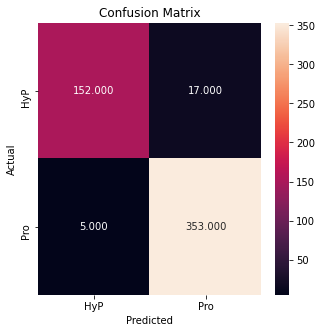

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predicted labels 
predictions = model.predict(test_data)
predictions = (predictions > 0.5).astype('int32')

# Get the true labels 
labels = test_label

# Plot the confusion matrix
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", xticklabels=['HyP', 'Pro'], yticklabels=['HyP', 'Pro']) 
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()